# Mezclado de regiones usando la ecuación de Poisson 

Trabajo final de visión por computador curso 2021-2022

Miembros equipo: 
- Exequiel Alberto Castro Rivero 
- Blanca Cano Camarero 

## Descripción del problema   
TODO: issue #8 redacción mejor cuando esté acabado 
Clonación de regiones   

## Elementos del problema   

Relacionaremos la notación usada de manera teórica: 

El dominio total de la imagen consiste en la unión de los píxeles 
$\Omega \cup S$. 

Donde $S$ representa  la posición de píxeles de la imagen destino que **no** modificarán su valor durante el clonado. 
A su vez, $\Omega$ representa a la área de la imagen destino que va a ser alterada. 
  
Todo pixel $p$ de $S \cup \Omega$ será un par que denotará sus coordenada dentro de la imagen. 
Y su **conjunto de vecinos del pixel $p$** denotado como $N_p$ serán calculados gracias a la función `Neighborhood` que definida en la celda de `Código: 1`. 


Será necesario calcular también el **borde  de $\Omega$**, que definíamos de manera formal como: 

$$\partial\Omega = \{ p \in S \setminus \Omega : N_p \cap \Omega \neq  \emptyset \} \quad (1)$$

Su cálculo se realizará mediante la función `SourceBoundary`, también definida en la celda `Código: 1`.

Falta ahora por definir el valor de cada pixel dentro de la imagen. Esto viene dado por las funciones 
$f: \Omega \longrightarrow \mathbb R$ que representa la función con la que realizaremos la interpolación y $f^*: S \longrightarrow \mathbb R$ que son los valores conocidos de la imagen destino. 


El objetivo a resolver de nuestro problema consiste en calcula $f$. 

Notación: Para una función cualquiera $h$ y un elemento de su dominio $x$, denotaremos a la imagen  $h(x)$ como $h_x$. 


In [1]:
# Código: 0   Import básico y otras definiciones globales auxiliares
import numpy as np
from itertools import chain # Herramienta de programación funcional

# Para la lectura de las imágenes
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Para las matrices dispersas
from scipy.sparse import lil_matrix
import scipy.sparse.linalg

# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'images/'

In [2]:
#Código: 1 Implementación de la funciones de cálculo de vecinos y borde

def Neighborhood(pixel : list, inputChannel : np.ndarray )->list:
    '''
    pixel: tupla o lista de dos números naturales que indican  las coordenadas del pixel. se comprobará que que es coherente con las dimensiones de la imagen
    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    '''
    x,y = pixel
    #Dimensiones de inputChannel coherente con el pixel demandado
    x_max , y_max = np.shape(inputChannel) 
    DimensionChecker = lambda x,y: 0 <= x < x_max and 0 <= y < y_max
    assert DimensionChecker(x,y), f' El pixel {pixel} se sale de las dimensiones {x_max}{y_max}'

    #Se devuelven vecino válidos
    neighborhoodCoordinates = filter(
        lambda tuple : DimensionChecker(tuple[0], tuple[1]),
        list( chain.from_iterable(([x+i,y], [x, y+i]) for i in [-1,1])) 
    )
   
    return list(neighborhoodCoordinates)


def SourceBoundary(inputChannel: np.ndarray, O: set )-> set : 
    '''
    Se pretenda calcular el borde de imagen destino. 

    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    O: Supondremos que O son n conjunto de pares de tuplas de coordenadas. 

    Devuelve un conjunto de coordenadas en tuplas que son el borde de O.
    ''' 
    # calculamos el conjunto de puntos S
    x_len, y_len = np.shape(inputChannel)
    S = set( (i,j) for i in range(x_len) for j in range(y_len)) 
    # Calculamos la diferencia 
    difference = S.difference(O)
    # Filtramos los puntos que cumplen la condición de que sus vecinos están en O (Omega)
    boundary = set(filter(
        lambda p : len(set(
            map(
                lambda l : tuple(l),
                Neighborhood(p, inputChannel)
            )
        ).intersection(O))>0,
        difference
    ))

    return boundary

### Complejidad de las funciones implementadas 

Para la función `Neighborhood(pixel : list, inputChannel : np.ndarray )`  de la celda `Código: 1` su eficiencia reside: 
- Coste funciones ya implementada de python y bibliotecas. 
- De nuestro propio código.   

La de nuestro propio código es $O(1)$ ya que no existe ningún bucle interno que dependenda de la entrada de la función. 
Para funciones externas la única función que podría contener un coste mayor de $O(1)$ podría ser la función `shape` de numpy. Consultando su implementación [1] se puede apreciar que usa dos funciones `len` que volviendo a analizar su eficiencia [2] esta es $O(1)$. 

Por lo que concluimos que `Neigborhood` tiene una complejidad de $O(1)$. 

TODO Complejidad de `SourceBoundary`. 

## Copiado prístino   

Para una implementación numérica, la traducción de las especificaciones continuas se trasladan directamente en : 

$v_{p,q} = g_p - g_q  \text { si } p,q \in \Omega \quad \text{  o   }\quad v_{p,q} = g_p - f_q \text{ si } q \in \partial \Omega,  p \in \Omega \quad (2)$ 



Donde $g_p$ representa el valor del pixel $p$ en la imagen de entrada y $f_p$ el valor de $p$ en la imagen de objetivo.
Así pues el resultado de la implementación queda escrito en la celda `Código: 2` la siguiente. 

In [3]:
# Código: 2 Implementación del campo de guía  

def GuidanceFieldGenerator(inputChannel : np.ndarray, targetChannel: np.ndarray):
    ''' Devuelve la función v_{p,q} = g_p - g_q$
    f_ = f^* Para el caso borde. 
    Para el caso particular en que g es inputChannel
    '''
    x_len, y_len = inputChannel.shape 

    def V (p,q):
       # calculamos g_p (nunca en el borde, luego)
        g_p = inputChannel[p[0]][p[1]]
        if q[0] < x_len and q[1] < y_len:
            g_q = inputChannel[q[0]][q[1]]
        else:
            g_q = targetChannel[q[0]][q[1]]
        return g_p - g_q
    return V
   

### Lectura de imágenes  

No olvidemos ahora la lectura de las imágenes. 

TODO: Aquí queda pensar cómo se va a leer para definir correctamente cada uno de los dominios. 

También será necesario buscar imágenes que sean adecuadas para nuestro problema, hemos realizado capturas del artículo original [3]. 

Para leer las imágenes utilizaremos las funciones de `opencv`, las leeremos en color. Como resultado (ver referencia a (1) en la salida de códico: 3)
obtendremos dos canales con los que trabajaremos de forma separada. 

Además podemos observar en la salida (1) que el número de píxeles de la imagen *Piel rugosa* es de $968 \times 1052$, mientras que para *Pintada de pared* es de $1092 \times 2138$.



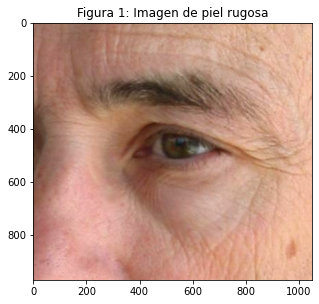

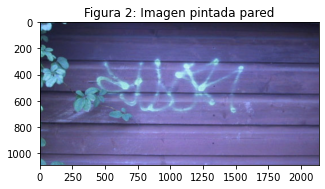

Salida (1) Sobre el tamaño de las imágenes: 
 Shape piel rugosa: (968, 1052, 3)
Shape pintada pared: (1092, 2138, 3)


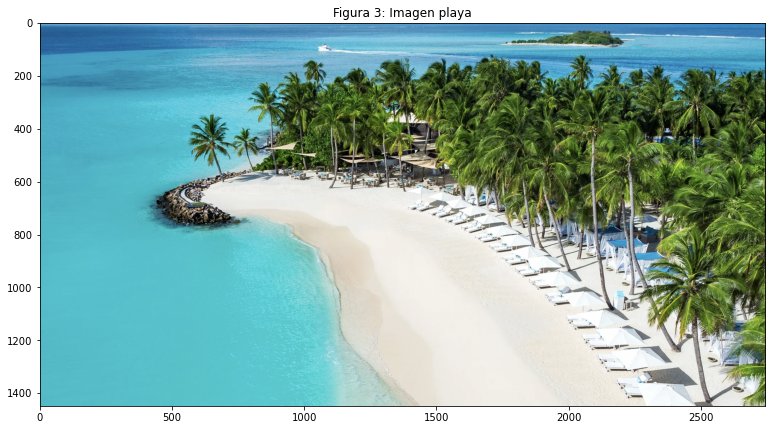

In [13]:
# Código: 3 Funciones lectura de imágenes 
'''
Salvo tener la necesidad de cambiar la ruta donde se leen las imágenes, no es necesario la lectura de ésta
celda, ya que contiene: 
1. Bibliotecas necesarias.
2. Indicación de la ruta de donde se toman las imágenes y la lectura de las imágenes.
3. Conjunto de funciones auxiliaras como las utilizadas para mostrar imágenes en pantalla. 
Éstas están tomadas de la práctica 0 y a lo sumo tienen ligeras modificaciones.  
'''
# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'images/'

# Devuelve si una imagen está en blanco o negro 
def IsGreyScale(img):
    '''Devuelve si una imagen está en blanco y negro'''
    return len(img.shape) == 2

# Reutilizamos código de la práctica inicial
def ReadImage(filename, flagColor):
  '''
  @param filename: nombre de la foto 
  @para flagColor: boolean escala de grises o color
  '''
  return np.asarray(cv.imread(filename, flagColor), dtype=float)
## Flags
flagColor = cv.IMREAD_ANYCOLOR
flagGrey = cv.IMREAD_GRAYSCALE


## Algunas funciones para pintar imágenes 
# Para pintar imágenes
def Normalize (img):
    ''' Transforma una imagen de números reales
    al intervalo [0,1] 
    '''
    min = np.min(img)
    max = np.max(img)

    normalized_img = np.copy(img)

    if max - min > 0:
        normalized_img = (normalized_img - min) / (max - min)
    else: 
        normalized_img *= 0 # suponemos todo blanca
    return normalized_img

def PrintOneImage( img, title=None, normalize= True, size = (13,13)):
    '''Muestra una imagen usando imshow'''

    plt.figure(figsize=size)
    if normalize:
        img = Normalize(img)
    if IsGreyScale(img):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if title:
        plt.title(title)
    plt.show()


## Leemos algunas imágenes y las mostramos  
pathPielRugosa = path + 'PielRugosa.png'
pathPintadaPared = path + 'PintadaEnPared.png'
imgPielRugosa = ReadImage(pathPielRugosa, flagColor) 
imgPintadaPared = ReadImage(pathPintadaPared, flagColor)
PrintOneImage(imgPielRugosa, title='Figura 1: Imagen de piel rugosa',size=(5,5))
PrintOneImage(imgPintadaPared, title='Figura 2: Imagen pintada pared', size=(5,5))

# Características de las imágenes 
print('Salida (1) Sobre el tamaño de las imágenes: ')
print(f' Shape piel rugosa: {imgPielRugosa.shape}')
print(f'Shape pintada pared: {imgPintadaPared.shape}')

#Playa 
pathPlaya = path + 'Playa2.png'
imgPlaya = ReadImage(pathPlaya, flagColor) 
PrintOneImage(imgPlaya, title='Figura 3: Imagen playa')

### Selección de regiones   

Es necesario definir un sistema de selección de regiones para nuestro problema, es decir de lo que de manera teórica sería definir las regiones $\Omega$ y $S$. Para ello hemos definido el siguiente método: 

Se subirán dos imágenes, una la original sin seleccionar el área, otra la que tiene el área seleccionada. Para indicar las regiones lo que se hará será cambiar cambiar el color de esa región. 

Mostramos ejemplo en  `Código: 5` y `Código: 6`. 

La implementación del cálculo, en sección `Código: 4` de región consiste en cambiar el color de las regiones que se quieren cambiar:
Se restan las matrices que representan las imágenes originales y la nueva, las entradas no nulas representa los píxeles seleccionados.
Este método supone un esfuerzo al que edita las imágenes: debe cambiar el color correctamente (es decir si lo hace coloreando esa región con un color, debe asegurarse de que ese color no está en ningún pixel de la zona. Para ello recomendamos usar algoritmos propios del sistema de edición con que edite la foto.)

Otro problema ahora a hacer frente es dónde posicionar esos píxeles en la otra imagen y con qué escala.
Eso se hará gracias a un homomorfismo. (TODO: issue #12 Revisar que la función utilizada es pegado regiones es homomorfismo).




In [15]:
# Código 4: Selección de regiones 

def SelectedRegion( originalImage: np.ndarray, selectedImage : np.ndarray, showImage = False, title = 'Regiones seleccionadas') -> set :
    '''
    Devuelve un conjunto de pares de coordenadas que han sido modificadas en alguno de los tres canales. 
    Su correspondencia teórica sería $\Omega$. 
    originalImage: Imagen en la que no se ha seleccionado ningún área. 
    selectedImage: Imagen con el área seleccionada. 
    showImage: Booleano si True muestra las regiones seleccionadas. 
    '''

    assert originalImage.shape == selectedImage.shape, f'El tamaño de las imágenes no son iguales, son de tamaño: {originalImage.shape} y {selectedImage.shape}'
    differenceMatrix = originalImage - selectedImage
    if(showImage):
        PrintOneImage(differenceMatrix, title= title,size=(7,7))
    #seleccionamos las coordenadas que han cambiado
    x_len, y_len, _ = differenceMatrix.shape
    selectedRegion = set()
    for x in range(x_len):
        for y in range(y_len): 
            if (
                differenceMatrix[x][y][0] != 0
                or differenceMatrix[x][y][1] != 0
                or differenceMatrix[x][y][2] != 0 
            ):
                selectedRegion.add((x,y))

    return selectedRegion

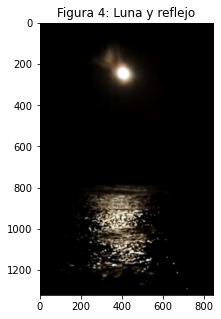

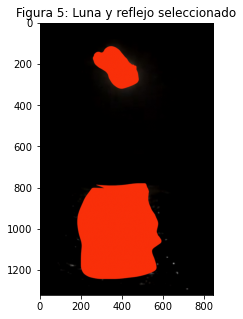

 Shape Luna y reflejo: (1322, 842, 3)
Shape luna y reflejo seleccionados: (1322, 842, 3)


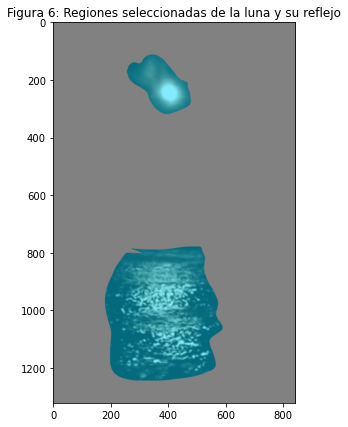

In [16]:
# Código 5: Ejemplo de selección de imágenes

#Leemos las imágenes y las mostramos 
pathLunaYReflejo = path + 'LunaYReflejo2.jpg'
pathLunaSeleccionada = path + 'LunaYReflejoSeleccionados2.jpg'
imgLunaYReflejo = ReadImage(pathLunaYReflejo, flagColor) 
imgLunaSeleccionada = ReadImage(pathLunaSeleccionada, flagColor)
PrintOneImage(imgLunaYReflejo, title='Figura 4: Luna y reflejo',size=(5,5))
PrintOneImage(imgLunaSeleccionada, title='Figura 5: Luna y reflejo seleccionado', size=(5,5))
# Imprimimos tamaño de las imágenes
print(f' Shape Luna y reflejo: {imgLunaYReflejo.shape}')
print(f'Shape luna y reflejo seleccionados: {imgLunaSeleccionada.shape}')
# Calculamos las diferencias y las mostramos en pantalla
setRegionesSeleccionadasLuna= SelectedRegion(imgLunaYReflejo, imgLunaSeleccionada, True, title='Figura 6: Regiones seleccionadas de la luna y su reflejo') 

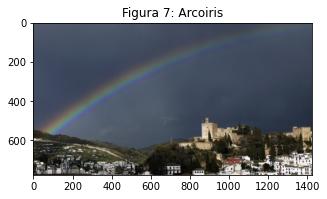

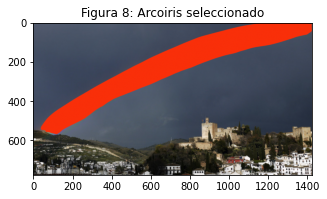

 Shape del arcoiris: (776, 1427, 3)
Shape arcoiris seleccionado: (776, 1427, 3)


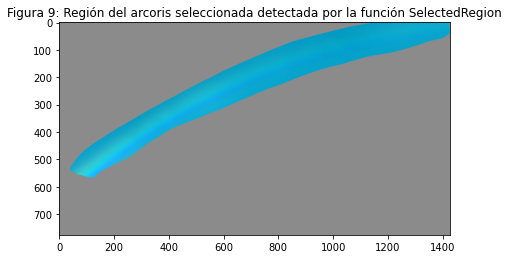

In [17]:
# Código 6: Ejemplo de selección de imágenes

#Leemos las imágenes y las mostramos 
pathArcoiris = path + 'Arcoiris.png'
pathArcoirisSeleccionado = path + 'ArcoirisSeleccionado.png'
imgArcoiris = ReadImage(pathArcoiris, flagColor) 
imgArcoirisSeleccionado = ReadImage(pathArcoirisSeleccionado, flagColor)
PrintOneImage(imgArcoiris, title='Figura 7: Arcoiris',size=(5,5))
PrintOneImage(imgArcoirisSeleccionado, title='Figura 8: Arcoiris seleccionado', size=(5,5))
# Imprimimos tamaño de las imágenes
print(f' Shape del arcoiris: {imgArcoiris.shape}')
print(f'Shape arcoiris seleccionado: {imgArcoirisSeleccionado.shape}')
# Calculamos las diferencias y las mostramos en pantalla
setRegionesSeleccionadasArcoiris= SelectedRegion(imgArcoiris, imgArcoirisSeleccionado, True, 'Figura 9: Región del arcoris seleccionada detectada por la función SelectedRegion') 


# Ejemplo de cálculo de borde 
Veremos ahora un ejemplo de cálculo del borde en la sección `Código: 7`. 

Será necesario: 
1. Separar la imagen en canales. 
2. Calcular en un canal el borde, que será el mismo para el resto de canales. 

Además para visualizar el borde se ha implementado en `Código: 7` la función `ViewBoundary`, que muestra en negro el borde. 
El resultado se recoge en la `Figura 10`, notemos que la línea negra es el borde calculado. 

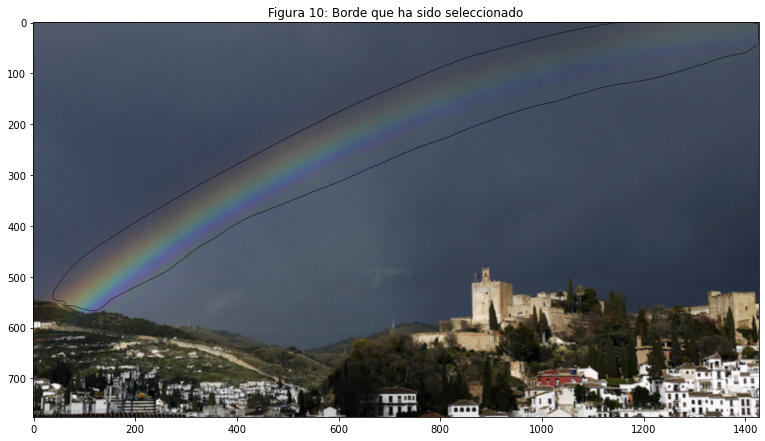

In [18]:
# Código 7: Ejemplo de cálculo del borde y función para visualizarlo 

def ViewBoundary (inputImage: np.ndarray , boundary: set): 
    '''Muestra en negro los puntos que han sido seleccionados como borde
    inputChannel: Imagen sobre la que se dibuja el borde.
    boundary: conjunto de pares de coordenadas sobre los que se va a dibujar
    '''
    new_image = np.copy(inputImage)
    for x,y in boundary:
        new_image[x][y][0] = new_image[x][y][1] = new_image[x][y][2] = 0.0
    PrintOneImage(new_image, 'Figura 10: Borde que ha sido seleccionado')

# Calculamos borde y lo mostramos 
channel = 0 # Channel of the image  
inputChannel = imgArcoiris[:, :, channel]
boundary = SourceBoundary(inputChannel, setRegionesSeleccionadasArcoiris)
ViewBoundary(imgArcoiris, boundary)

# Discrete Poisson Solver  

Centrémonos ahora en el objetivo principal que es calcula la función de interpolación $f_p$. Para ello, como hemos explicado en la memoria; es necesario resolver el sistema: 

Para todo $p \in \Omega$
$$|N_p| f_p - \sum_{q \in N_p \cap \Omega} f_q = \sum _{q \in N_p \cap \partial \Omega} f_q ^* + \sum_{q \in N_p} v_{pq}. \quad (3)$$  

Donde $f_p$ y $f_q$ son las incógnitas. 

La implementación se realiza en la  celda `Código 8` y está compuesta de: 
 
La función `OneChannelDiscretePoissonSolver` que  computa el valor de la función de interpolación en todos los puntos $p \in \Omega$, donde $\Omega$, como ya hemos indicado con anterioridad, es el conjunto de píxeles (previamente definidos) de la imagen fuente que se van a clonar. Para ello se siguen los siguientes pasos:
1. Se computa el borde de la región donde se realiza la inserción: $\partial \Omega$, necesario para los cómputos posteriores.
2. Se obtiene la función que obtiene el vector de guía de campo, $v$.
3. Se define la matriz de que almacena los coeficientes de las incógnitas, `equation`. Como hay $n=|\Omega|$ incógnitas definiremos una matriz $n \times n$. Nótese que la mayoría de elementos de esta matriz tendrán valor cero (sea cual sea el número de incógnitas, el número de elementos distinto de cero en cada fila es: $|p| + |N_p| \leq 5$). Con una matriz tradicional, para regiones medianamente grandes, esto puede suponer un coste inabordable de memoria. Es por esta razón por la que se usa una matriz dispersa, las cuales vienen implementadas en la biblioteca `scipy`. En particular, en nuestra implementación se usará una matriz dispersa tipo `lil_matrix`. Para más información revisar referencia [4].
4. Se define un array para almacenar los valores de los términos independientes, `terms`.
5. Se rellena la matriz de coeficientes y el array de términos independientes tal y como se define en el paper (ver ecuación anterior).
6. Se resuelve el sistema de ecuaciones con la función `sparse.linalg.spsolve` de la librería `scipy`, para el caso especial de matrices dispersas. Para más información revisar referencia [5].

Posteriormente la función `MultipleChannelDiscretePoissonSolver` computa el valor de la función de interpolación para todos los canales de la imagen haciendo uso de la función previamente comentada. Al mismo tiempo va realizando el cambio de los valores de los píxeles (en cada canal, de manera separada) por los encontrados con la función de interpolación, $f$.


In [10]:
# Código 8: Cálculo de la función de interpolación

def OneChannelDiscretePoissonSolver( source, targetImg, selectedSet):
    ''' Devuelve f, la función interpolación para los canales dados
    source: Imagen de la que se extrae la región que se quiere clonar
    targetImg:  Imagen donde se va a posicionar la nueva región 
    selectedSet: Conjunto de puntos con las región selecciónada, a de calcularse previamente
    '''
    # Calculamos borde del arcoiris 
    sourceBoundary = SourceBoundary(targetImg, selectedSet)  #TODO issue#14

    # Calculamos el campo de escalares 
    V = GuidanceFieldGenerator(source,targetImg) # imagen original de la que se extrae la región seleccionada
                                                 # Nótese que aquí se trabaja con las coordenadas de esos píxeles
                                                 # TODO: Modificar la función para el vector de guía pueda ser un parámetro

    # Cálculo de valores necesarios
    omega_len = len(selectedSet)
    equation = lil_matrix((omega_len, omega_len), dtype = np.int8)
    terms = np.zeros(omega_len)

    column = {}
    # Se almacenan los índices de los puntos en un diccionario: p -> índice matriz
    for index,p in enumerate(selectedSet):
        column[p] = index
    
    # Escribimos el sistema de ecuaciones
    for index,p in enumerate(selectedSet):
        # Cálculo de N_p, vecinos
        Np = Neighborhood(p, targetImg)
        Np_cardinality = len(Np)
        # Entrada para |N_p| f_p 
        equation[index, index] = Np_cardinality
        # Operaciones que involucran vecinos
        for q in Np:
            q = tuple(q)
            # Entrada para  - \sum_{q \in N_p \cap \Omega} f_q 
            if q in selectedSet:
                equation[index, column[q]] = -1
            # Término independiente equación: \sum_{q \in N_p} v_{pq}
            terms[index] += V(p,q)
            # Término independiente \sum _{q \in N_p \cap \partial \Omega} f_q ^* 
            if q in sourceBoundary:
                terms[index] += targetImg[q[0]][q[1]]
    # Resolvemos sistema
    f = scipy.sparse.linalg.spsolve(equation.tocsr(True), terms)
    return f

def MultipleChannelDiscretePoissonSolver( multiChannelSource, multiChannelTargetImg, selectedSet):
    '''
    Se calcula f, la función de interpolación para cada cada canal, y se realiza la sustitución de los valores
    de los píxeles de la región seleccionada por los de la función de interpolación.
    multiChannelSource: imagen multicanal que se desea copiar.
    multiChannelTargetImg: imagen multicanal sobre la que se desea insertar la imagen fuente.
    selectedSet: conjunto de puntos que definen la región de la imagen destino donde se va a realizar la inserción de la imagen fuente.
    '''
    # Copiado de la imagen para no transformar la imagen original
    seamlessImg = np.copy(multiChannelTargetImg)

    # Se itera sobre todos los canales de la imagen
    for i in range(3):
        source = multiChannelSource[:,:,i] # Imagen de la que se extrae la región que se quiere clonar
        targetImg = multiChannelTargetImg[:,:,i]  # Imagen donde se va a posicionar la nueva región 
        f = OneChannelDiscretePoissonSolver(source, targetImg, selectedSet) # Cómputo de la función de interpolación para el canal

        # Se actualizan los valores de la región
        for index,p in enumerate(selectedSet):
            seamlessImg[p[0], p[1],i] = f[index]
    
    return seamlessImg

# Ejemplo de cálculo de interpolación

Con el fin de mostrar un ejemplo de imagen resultante de nuestra implementación puede ver la `Figura 11`. Calculada en el `Código: 9` donde el arcoiris de la `Figura: 7` se clona en la playa de la `Figura 3`. 
Como campo de vectores guía se ha utilizado el definido en $(2)$, el más básico.   

## Tiempo de cómputo  

Para el `equipo 1` el tiempo de cóputo ha sido 51 segundos. 

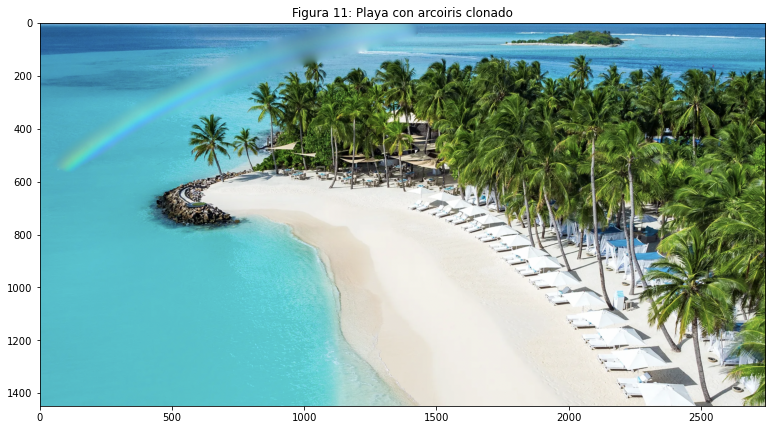

In [19]:
# Código 9: Ejemplo de cálculo de interpolación: playa con arcoiris 
seamlessImg = MultipleChannelDiscretePoissonSolver(imgArcoiris, imgPlaya, setRegionesSeleccionadasArcoiris)
PrintOneImage(seamlessImg, 'Figura 11: Playa con arcoiris clonado')


# Bibliografía y otros recursos  

[1] Web. Título: Implementación de funciones de la función `shape`. URL: https://github.com/pandas-dev/pandas/blob/master/pandas/core/frame.py Fecha última consulta: 01-01-22. Línea de código: 822-842.

[2] Web. Título: *Internal working of the Len() function in Python. URL: https://www.geeksforgeeks.org/internal-working-of-the-len-function-in-python/ autor: GeeksforGeeks. Fecha última consulta: 01-01-22. 

[3] Artículo *Poisson Image Editing* Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. DOI:https://doi.org/10.1145/882262.882269

[4] Web. Título: Documentación del tipo de dato `lil_matrix`. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html Fecha última consulta: 05-01-22.

[5] Web. Título: Documentación de la función que resuelve sistemas de ecuaciones lineares `spsolve`. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html Fecha última consulta: 05-01-22.

# Equipos con los que se han realizado los cómputos   

`Equipo 1`: Macbook pro m1 32gb ram, 10 núcleos de CPU, 16 de GPU. 